In [87]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time

In [68]:
path='./datasets/cat-dog/'

In [69]:
files=glob(os.path.join(path,'train/*.jpg'))

In [70]:
print(f'Total no of images {len(files)}')

Total no of images 25000


In [71]:
no_of_images = 25000

In [72]:
no_of_images = len(files)

In [73]:
no_of_images*0.8

20000.0

In [74]:
shuffle = np.random.permutation(no_of_images)

In [75]:
os.mkdir(os.path.join(path,'valid'))

In [76]:
for t in ['train','valid']:
    for folder in ['dog/','cat/']:
        os.mkdir(os.path.join(path,t,folder))

In [77]:
for i in shuffle[:2000]:
    #shutil.copyfile(files[i],'../chapter3/dogsandcats/valid/')
    folder = files[i].split('/')[-1].split('.')[0]
    image = files[i].split('/')[-1]
    os.rename(files[i],os.path.join(path,'valid',folder,image))

In [78]:
for i in shuffle[2000:]:
    #shutil.copyfile(files[i],'../chapter3/dogsandcats/valid/')
    folder = files[i].split('/')[-1].split('.')[0]
    image = files[i].split('/')[-1]
    os.rename(files[i],os.path.join(path,'train',folder,image))

In [79]:
if torch.cuda.is_available():
    is_cuda = True

In [88]:
#이미지 로딩

simple_transform=transforms.Compose([transforms.Scale((224,224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
train=ImageFolder('./datasets/cat-dog/train/',simple_transform)
valid=ImageFolder('./datasets/cat-dog/valid/',simple_transform)

In [89]:
print(train.class_to_idx)
print(train.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


In [90]:
def imshow(inp):
    
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485,0.456,0.406])
    std=np.array([0.229,0.224,0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)

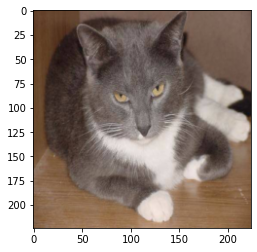

In [91]:
imshow(train[50][0])

In [93]:
#데이터 제러레이션

train_data_gen=torch.utils.data.DataLoader(train,batch_size=64,num_workers=3)
valid_data_gen=torch.utils.data.DataLoader(valid,batch_size=64,num_workers=3)

dataset_sizes={'train':len(train_data_gen.dataset),'valid':len(valid_data_gen.dataset)}
dataloaders={'train':train_data_gen,'valid':valid_data_gen}

In [95]:
dataset_sizes
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f6310a8eed0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f6310a8e6d0>}

In [102]:
model_ft=models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=nn.Linear(num_ftrs,2)

if torch.cuda.is_available():
    model_ft=model_ft.cuda()

In [103]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [109]:
#모델 학습

learning_rate=0.001
criterion=nn.CrossEntropyLoss()
optimizer_ft=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

In [116]:
def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since=time.time()
    
    best_model_wts=model.state_dict()
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        for phase in ['train','valid']:
            if phase =='train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
                
            running_loss=0.0
            running_corrects=0
            
            for data in dataloaders[phase]:
                inputs,labels=data
                
                if is_cuda:
                    inputs=Variable(inputs.cuda())
                    labels=Variable(labels.cuda())
                    
                else:
                    inputs,labels=Variable(inputs),Variable(labels)
                    
                    
                optimizer.zero_grad()
                
                outputs=model(inputs)
                _,preds=torch.max(outputs.data,1)
                loss=criterion(outputs,labels)
                
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss+=loss.data
                running_corrects+=torch.sum(preds==labels.data)
                
            epoch_loss=running_loss.item()/dataset_sizes[phase]
            epoch_acc=running_corrects.item()/dataset_sizes[phase]
            
            print('{} Loss : {:.4f} Acc : {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            if phase=='valid' and epoch_acc > best_acc:
                best_acc=epoch_acc
                best_model_wts=model.state_dict()
                
        print()
        
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed% 60))
    print('Best val Acc:{:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [117]:
%%time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=24)

Epoch 0/23
----------
train Loss : 0.0110 Acc : 0.4993
valid Loss : 0.0159 Acc : 0.4940

Epoch 1/23
----------
train Loss : 0.0109 Acc : 0.5003
valid Loss : 0.0159 Acc : 0.4940

Epoch 2/23
----------
train Loss : 0.0109 Acc : 0.5003
valid Loss : 0.0160 Acc : 0.4940

Epoch 3/23
----------
train Loss : 0.0109 Acc : 0.5003
valid Loss : 0.0160 Acc : 0.4940

Epoch 4/23
----------


KeyboardInterrupt: 